# Beach Crowd Prediction — TFT Temporal Chunking

Compares **NeuralForecast TFT** vs **PyTorch-Forecasting TFT** (daytime-only) across:
1. **Simple Sliding** — 2 chunks train, 1 val, 1 test
2. **Expanding Rolling** — growing train, 1 val, 1 test
3. **Split-Gap** — 40% early + 40% late (20% gap), simulating 2022+2025 data

In [1]:
# === PATHS ===
CACHE_DIR = "cache/predictions"
COUNTING_MODEL = "bayesian_vgg19"
SAVE_DIR = "models/tft_chunks"

# === SAMPLING ===
SAMPLE_FRAC = 1.0
MAX_BEACHES = None

# === TFT PARAMETERS ===
MAX_STEPS = 500
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
INPUT_SIZE = 48
HORIZON = 168  # 1 week = 7 days

# === TIME ===
NIGHT_START = 20
NIGHT_END = 6

# === FLAGS ===
RUN_SKLEARN = False
RUN_NEURALFORECAST = True
RUN_OPTUNA = False

In [2]:
import subprocess, sys
for pkg in ["neuralforecast", "utilsforecast"]:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

In [3]:
import json, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

import torch
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.losses.pytorch import MAE

HAS_NF = True

if torch.cuda.is_available():
    ACCELERATOR = 'gpu'
    DEVICES = 1
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    ACCELERATOR = 'mps'
    DEVICES = 1
else:
    ACCELERATOR = 'cpu'
    DEVICES = 1

print(f"Device: {ACCELERATOR} | PyTorch: {torch.__version__}")

Device: mps | PyTorch: 2.9.1


In [4]:
def calc_metrics(y_true, y_pred, max_count):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    rel_mae = (mae / max_count) * 100 if max_count > 0 else 0
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'RelMAE': rel_mae}

def eval_per_beach(df, y_pred, beach_col='unique_id'):
    results = []
    for b in df[beach_col].unique():
        mask = df[beach_col] == b
        if mask.sum() < 3:
            continue
        y_true = df.loc[mask, 'y'].values if 'y' in df.columns else df.loc[mask, 'count'].values
        y_p = y_pred[mask.values] if hasattr(mask, 'values') else y_pred[mask]
        max_count = y_true.max()
        m = calc_metrics(y_true, y_p, max_count)
        m['camera'] = b
        m['max_count'] = max_count
        m['n'] = mask.sum()
        results.append(m)
    return pd.DataFrame(results)

## Load and Prepare Data

In [5]:
def load_cache(cache_dir, model):
    cache_path = Path(cache_dir) / model
    records = []
    for jf in cache_path.rglob("*.json"):
        try:
            with open(jf) as f:
                r = json.load(f)
            if 'error' not in r:
                records.append(r)
        except: pass
    
    rows = []
    for r in records:
        row = {
            'beach': r.get('beach') or r.get('beach_folder'),
            'beach_folder': r.get('beach_folder'),
            'datetime': r.get('datetime'),
            'count': r.get('count')
        }
        for k, v in r.get('weather', {}).items():
            row[k] = v
        rows.append(row)
    
    df = pd.DataFrame(rows)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    return df

df_raw = load_cache(CACHE_DIR, COUNTING_MODEL)
print(f"Loaded: {len(df_raw)} rows, {df_raw['beach'].nunique()} beaches")

Loaded: 169241 rows, 41 beaches


In [6]:
EXCLUDE = ['livecampro/001', 'livecampro/011', 'livecampro/018', 'livecampro/021',
    'livecampro/030', 'livecampro/039', 'livecampro/070', 'MultimediaTres/PortAndratx',
    'SeeTheWorld/mallorca_pancam', 'skyline/es-pujols']
EXCLUDE_PREFIX = ['ibred', 'ClubNauticSoller', 'Guenthoer', 'youtube']

before = len(df_raw)
df_raw = df_raw[~df_raw['beach_folder'].isin(EXCLUDE)]
for p in EXCLUDE_PREFIX:
    df_raw = df_raw[~df_raw['beach_folder'].str.startswith(p, na=False)]
print(f"Filtered: {before} -> {len(df_raw)}")

Filtered: 169241 -> 70501


In [7]:
if SAMPLE_FRAC < 1.0:
    df_raw = df_raw.sample(frac=SAMPLE_FRAC, random_state=42).sort_values('datetime').reset_index(drop=True)

if MAX_BEACHES:
    top = df_raw['beach'].value_counts().head(MAX_BEACHES).index.tolist()
    df_raw = df_raw[df_raw['beach'].isin(top)].reset_index(drop=True)

print(f"Final: {len(df_raw)} rows, {df_raw['beach'].nunique()} beaches")

Final: 70501 rows, 14 beaches


In [8]:
df = df_raw.copy()
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_night'] = ((df['hour'] >= NIGHT_START) | (df['hour'] <= NIGHT_END)).astype(int)

WEATHER_COLS = [c for c in df.columns if c.startswith('ae_') or c.startswith('om_')]
TEMPORAL_COLS = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_summer', 'is_night']
ALL_FEATURES = WEATHER_COLS + TEMPORAL_COLS

df = df.dropna(subset=ALL_FEATURES + ['count']).reset_index(drop=True)
good = df.groupby('beach')['count'].max()
good = good[good > 20].index.tolist()
df = df[df['beach'].isin(good)].reset_index(drop=True)

print(f"After cleaning: {len(df)} rows, {len(good)} beaches")
print(f"Features: {len(ALL_FEATURES)}")

After cleaning: 70090 rows, 14 beaches
Features: 35


## Create Three Dataset Strategies

In [9]:
ds_daytime = df[df['is_night'] == 0].copy().reset_index(drop=True)
ds_full24h = df.copy()
ds_night0 = df.copy()
ds_night0.loc[ds_night0['is_night'] == 1, 'count'] = 0.0

ds_nightq1 = df.copy()
q1_per_beach = ds_nightq1[ds_nightq1['is_night'] == 0].groupby('beach')['count'].quantile(0.25)
ds_nightq1.loc[ds_nightq1['is_night'] == 1, 'count'] = ds_nightq1.loc[ds_nightq1['is_night'] == 1, 'beach'].map(q1_per_beach).fillna(0)

ds_nightmin = df.copy()
min_per_beach = ds_nightmin[ds_nightmin['is_night'] == 0].groupby('beach')['count'].min()
ds_nightmin.loc[ds_nightmin['is_night'] == 1, 'count'] = ds_nightmin.loc[ds_nightmin['is_night'] == 1, 'beach'].map(min_per_beach).fillna(0)

datasets = {'Daytime': ds_daytime, 'Full24h': ds_full24h, 'Night0': ds_night0, 'NightQ1': ds_nightq1, 'NightMin': ds_nightmin}

print("=" * 80)
print("DATASET COMPARISON")
print("=" * 80)

for name, d in datasets.items():
    night_rows = d[d['is_night'] == 1] if 'is_night' in d.columns else pd.DataFrame()
    day_rows = d[d['is_night'] == 0] if 'is_night' in d.columns else d
    
    print(f"\n{name}:")
    print(f"  Total rows:     {len(d)}")
    print(f"  Beaches:        {d['beach'].nunique()}")
    print(f"  Night rows:     {len(night_rows)} ({len(night_rows)/len(d)*100:.1f}%)")
    print(f"  Day rows:       {len(day_rows)} ({len(day_rows)/len(d)*100:.1f}%)")
    print(f"  Count mean:     {d['count'].mean():.1f}")
    print(f"  Count max:      {d['count'].max():.1f}")
    print(f"  Zeros:          {(d['count'] == 0).sum()} ({(d['count'] == 0).sum()/len(d)*100:.1f}%)")

DATASET COMPARISON

Daytime:
  Total rows:     37643
  Beaches:        14
  Night rows:     0 (0.0%)
  Day rows:       37643 (100.0%)
  Count mean:     57.2
  Count max:      538.0
  Zeros:          0 (0.0%)

Full24h:
  Total rows:     70090
  Beaches:        14
  Night rows:     32447 (46.3%)
  Day rows:       37643 (53.7%)
  Count mean:     53.8
  Count max:      538.0
  Zeros:          0 (0.0%)

Night0:
  Total rows:     70090
  Beaches:        14
  Night rows:     32447 (46.3%)
  Day rows:       37643 (53.7%)
  Count mean:     30.7
  Count max:      538.0
  Zeros:          32447 (46.3%)

NightQ1:
  Total rows:     70090
  Beaches:        14
  Night rows:     32447 (46.3%)
  Day rows:       37643 (53.7%)
  Count mean:     50.1
  Count max:      538.0
  Zeros:          0 (0.0%)

NightMin:
  Total rows:     70090
  Beaches:        14
  Night rows:     32447 (46.3%)
  Day rows:       37643 (53.7%)
  Count mean:     42.0
  Count max:      538.0
  Zeros:          0 (0.0%)


In [10]:
from utilsforecast.preprocessing import fill_gaps

def to_nf_format(df, id_col='beach_folder'):
    cols = ['datetime', id_col, 'count'] + ALL_FEATURES
    cols = [c for c in cols if c in df.columns]
    nf_df = df[cols].copy()
    nf_df = nf_df.rename(columns={'datetime': 'ds', id_col: 'unique_id', 'count': 'y'})
    return nf_df

def prepare_nf_data(df, freq='h'):
    nf = to_nf_format(df)
    nf = nf.groupby(['unique_id', 'ds']).mean(numeric_only=True).reset_index()
    nf = fill_gaps(nf, freq=freq)
    for col in nf.select_dtypes(include=[np.number]).columns:
        nf[col] = nf.groupby('unique_id')[col].transform(
            lambda x: x.interpolate(method='linear').ffill().bfill()
        )
    return nf

def create_temporal_chunks(df, n_chunks=6):
    date_min = df['datetime'].min()
    date_max = df['datetime'].max()
    total_days = (date_max - date_min).days
    chunk_days = total_days // n_chunks
    boundaries = []
    for i in range(n_chunks + 1):
        boundaries.append(date_min + pd.Timedelta(days=i * chunk_days))
    boundaries[-1] = date_max + pd.Timedelta(hours=1)
    chunks = []
    for i in range(n_chunks):
        mask = (df['datetime'] >= boundaries[i]) & (df['datetime'] < boundaries[i+1])
        chunk = df[mask].copy()
        chunks.append({
            'data': chunk,
            'start': boundaries[i],
            'end': boundaries[i+1] - pd.Timedelta(hours=1),
            'label': f"C{i+1}: {boundaries[i].strftime('%b %d')}\u2192{(boundaries[i+1]-pd.Timedelta(hours=1)).strftime('%b %d')}"
        })
    return chunks, boundaries

N_CHUNKS = 6

date_min = df['datetime'].min()
date_max = df['datetime'].max()
total_days = (date_max - date_min).days

print("=" * 70)
print(f"TEMPORAL CHUNKING: {total_days} days \u2192 {N_CHUNKS} chunks of ~{total_days//N_CHUNKS} days")
print(f"Date range: {date_min.date()} to {date_max.date()}")
print("=" * 70)

all_chunks = {}
for ds_name in datasets.keys():
    chunks, boundaries = create_temporal_chunks(datasets[ds_name], N_CHUNKS)
    all_chunks[ds_name] = chunks
    print(f"\n{ds_name}:")
    for c in chunks:
        print(f"  {c['label']} | {len(c['data'])} rows")

# --- SIMPLE SLIDING: train=2 chunks, val=1, test=1 ---
print("\n" + "=" * 70)
print("SIMPLE SLIDING WINDOW (train=2 chunks, val=1, test=1)")
print("=" * 70)

simple_windows_all = {}
for ds_name in datasets.keys():
    chunks = all_chunks[ds_name]
    windows = []
    for i in range(len(chunks) - 3):
        train_data = pd.concat([chunks[i]['data'], chunks[i+1]['data']])
        windows.append({
            'name': f"SW{i+1}",
            'train_chunks': [chunks[i], chunks[i+1]],
            'train_data': train_data,
            'val_data': chunks[i+2]['data'],
            'test_data': chunks[i+3]['data'],
            'train_label': f"{chunks[i]['label'].split(':')[0]}+{chunks[i+1]['label'].split(':')[0]} (2 chunks)",
            'val_label': chunks[i+2]['label'],
            'test_label': chunks[i+3]['label'],
        })
    simple_windows_all[ds_name] = windows
    print(f"\n{ds_name}:")
    for w in windows:
        print(f"  {w['name']}: Train={w['train_label']} ({len(w['train_data'])} rows) | "
              f"Val={w['val_label']} | Test={w['test_label']}")

# --- ROLLING WINDOWS: train=expanding, val=1, test=1 ---
print("\n" + "=" * 70)
print("ROLLING WINDOW EXPERIMENTS (train=expanding, val=1 chunk, test=1 chunk)")
print("=" * 70)

rolling_windows = {}
for ds_name in datasets.keys():
    chunks = all_chunks[ds_name]
    windows = []
    for test_idx in range(2, N_CHUNKS):
        val_idx = test_idx - 1
        train_chunks = chunks[:val_idx]
        windows.append({
            'name': f"W{len(windows)+1}",
            'train_chunks': train_chunks,
            'train_data': pd.concat([c['data'] for c in train_chunks]),
            'val_data': chunks[val_idx]['data'],
            'test_data': chunks[test_idx]['data'],
            'train_label': f"{train_chunks[0]['label'].split(':')[0]}\u2192{train_chunks[-1]['label'].split(':')[0]} ({len(train_chunks)} chunks)",
            'val_label': chunks[val_idx]['label'],
            'test_label': chunks[test_idx]['label'],
        })
    rolling_windows[ds_name] = windows
    print(f"\n{ds_name}:")
    for w in windows:
        print(f"  {w['name']}: Train={w['train_label']} ({len(w['train_data'])} rows) | "
              f"Val={w['val_label']} | Test={w['test_label']}")

# --- SPLIT-GAP: first 40% + last 40%, skip middle 20% ---
print("\n" + "=" * 70)
print("SPLIT-GAP EXPERIMENT (40% early | 20% gap | 40% late)")
print("Simulates: 2022 data + 2025 data, no data in between")
print("=" * 70)

split_gap_windows = {}
for ds_name in datasets.keys():
    ds = datasets[ds_name].sort_values('datetime').reset_index(drop=True)
    n = len(ds)
    early = ds.iloc[:int(n * 0.4)]
    late = ds.iloc[int(n * 0.6):]
    gap_start = ds.iloc[int(n * 0.4)]['datetime']
    gap_end = ds.iloc[int(n * 0.6)]['datetime']

    def split_period(period_df, period_name):
        np_ = len(period_df)
        tr = period_df.iloc[:int(np_ * 0.6)]
        va = period_df.iloc[int(np_ * 0.6):int(np_ * 0.8)]
        te = period_df.iloc[int(np_ * 0.8):]
        return {
            'name': period_name,
            'train_data': tr, 'val_data': va, 'test_data': te,
            'train_label': f"{period_name} train ({tr['datetime'].min().strftime('%b %d')}\u2192{tr['datetime'].max().strftime('%b %d')})",
            'val_label': f"{period_name} val ({va['datetime'].min().strftime('%b %d')}\u2192{va['datetime'].max().strftime('%b %d')})",
            'test_label': f"{period_name} test ({te['datetime'].min().strftime('%b %d')}\u2192{te['datetime'].max().strftime('%b %d')})",
        }

    early_split = split_period(early, "Early")
    late_split = split_period(late, "Late")
    combined_train = pd.concat([early_split['train_data'], late_split['train_data']])
    combined = {
        'name': "Combined",
        'train_data': combined_train,
        'val_data': late_split['val_data'],
        'test_data': late_split['test_data'],
        'train_label': f"Early+Late train ({len(combined_train)} rows, gap={gap_start.strftime('%b %d')}\u2192{gap_end.strftime('%b %d')})",
        'val_label': late_split['val_label'],
        'test_label': late_split['test_label'],
    }
    split_gap_windows[ds_name] = {
        'early': early_split, 'late': late_split, 'combined': combined,
        'gap_start': gap_start, 'gap_end': gap_end,
    }
    print(f"\n{ds_name}:")
    print(f"  Early: {early['datetime'].min().strftime('%b %d')} \u2192 {early['datetime'].max().strftime('%b %d')} ({len(early)} rows)")
    print(f"  Gap:   {gap_start.strftime('%b %d')} \u2192 {gap_end.strftime('%b %d')}")
    print(f"  Late:  {late['datetime'].min().strftime('%b %d')} \u2192 {late['datetime'].max().strftime('%b %d')} ({len(late)} rows)")
    for exp in [early_split, late_split, combined]:
        print(f"    {exp['name']:10s} | train={len(exp['train_data']):5d} | val={len(exp['val_data']):5d} | test={len(exp['test_data']):5d}")


TEMPORAL CHUNKING: 194 days → 6 chunks of ~32 days
Date range: 2022-07-14 to 2023-01-24

Daytime:
  C1: Jul 14→Aug 15 | 6420 rows
  C2: Aug 15→Sep 16 | 6369 rows
  C3: Sep 16→Oct 18 | 5686 rows
  C4: Oct 18→Nov 19 | 6042 rows
  C5: Nov 19→Dec 21 | 6293 rows
  C6: Dec 21→Jan 24 | 6833 rows

Full24h:
  C1: Jul 14→Aug 15 | 11955 rows
  C2: Aug 15→Sep 16 | 11877 rows
  C3: Sep 16→Oct 18 | 10584 rows
  C4: Oct 18→Nov 19 | 11192 rows
  C5: Nov 19→Dec 21 | 11824 rows
  C6: Dec 21→Jan 24 | 12658 rows

Night0:
  C1: Jul 14→Aug 15 | 11955 rows
  C2: Aug 15→Sep 16 | 11877 rows
  C3: Sep 16→Oct 18 | 10584 rows
  C4: Oct 18→Nov 19 | 11192 rows
  C5: Nov 19→Dec 21 | 11824 rows
  C6: Dec 21→Jan 24 | 12658 rows

NightQ1:
  C1: Jul 14→Aug 15 | 11955 rows
  C2: Aug 15→Sep 16 | 11877 rows
  C3: Sep 16→Oct 18 | 10584 rows
  C4: Oct 18→Nov 19 | 11192 rows
  C5: Nov 19→Dec 21 | 11824 rows
  C6: Dec 21→Jan 24 | 12658 rows

NightMin:
  C1: Jul 14→Aug 15 | 11955 rows
  C2: Aug 15→Sep 16 | 11877 rows
  C3: Sep 

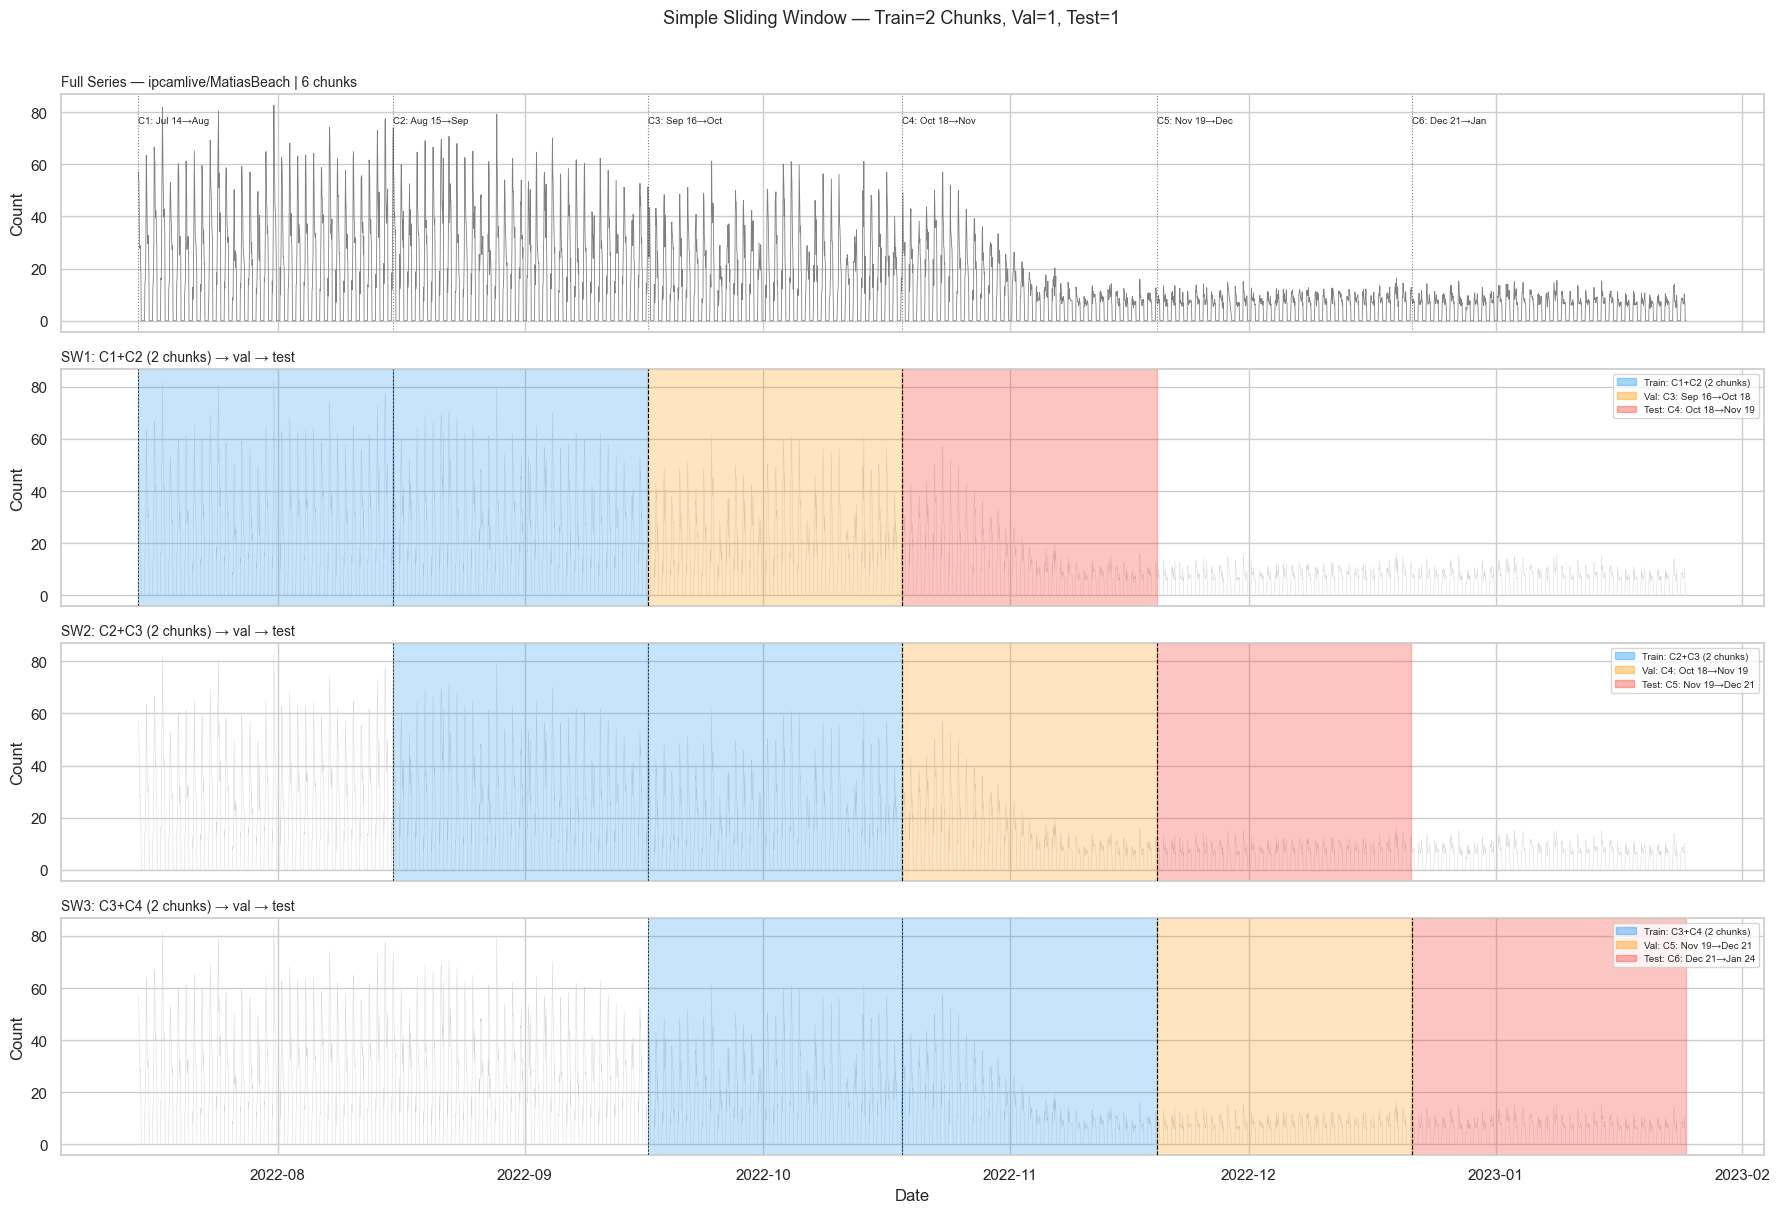

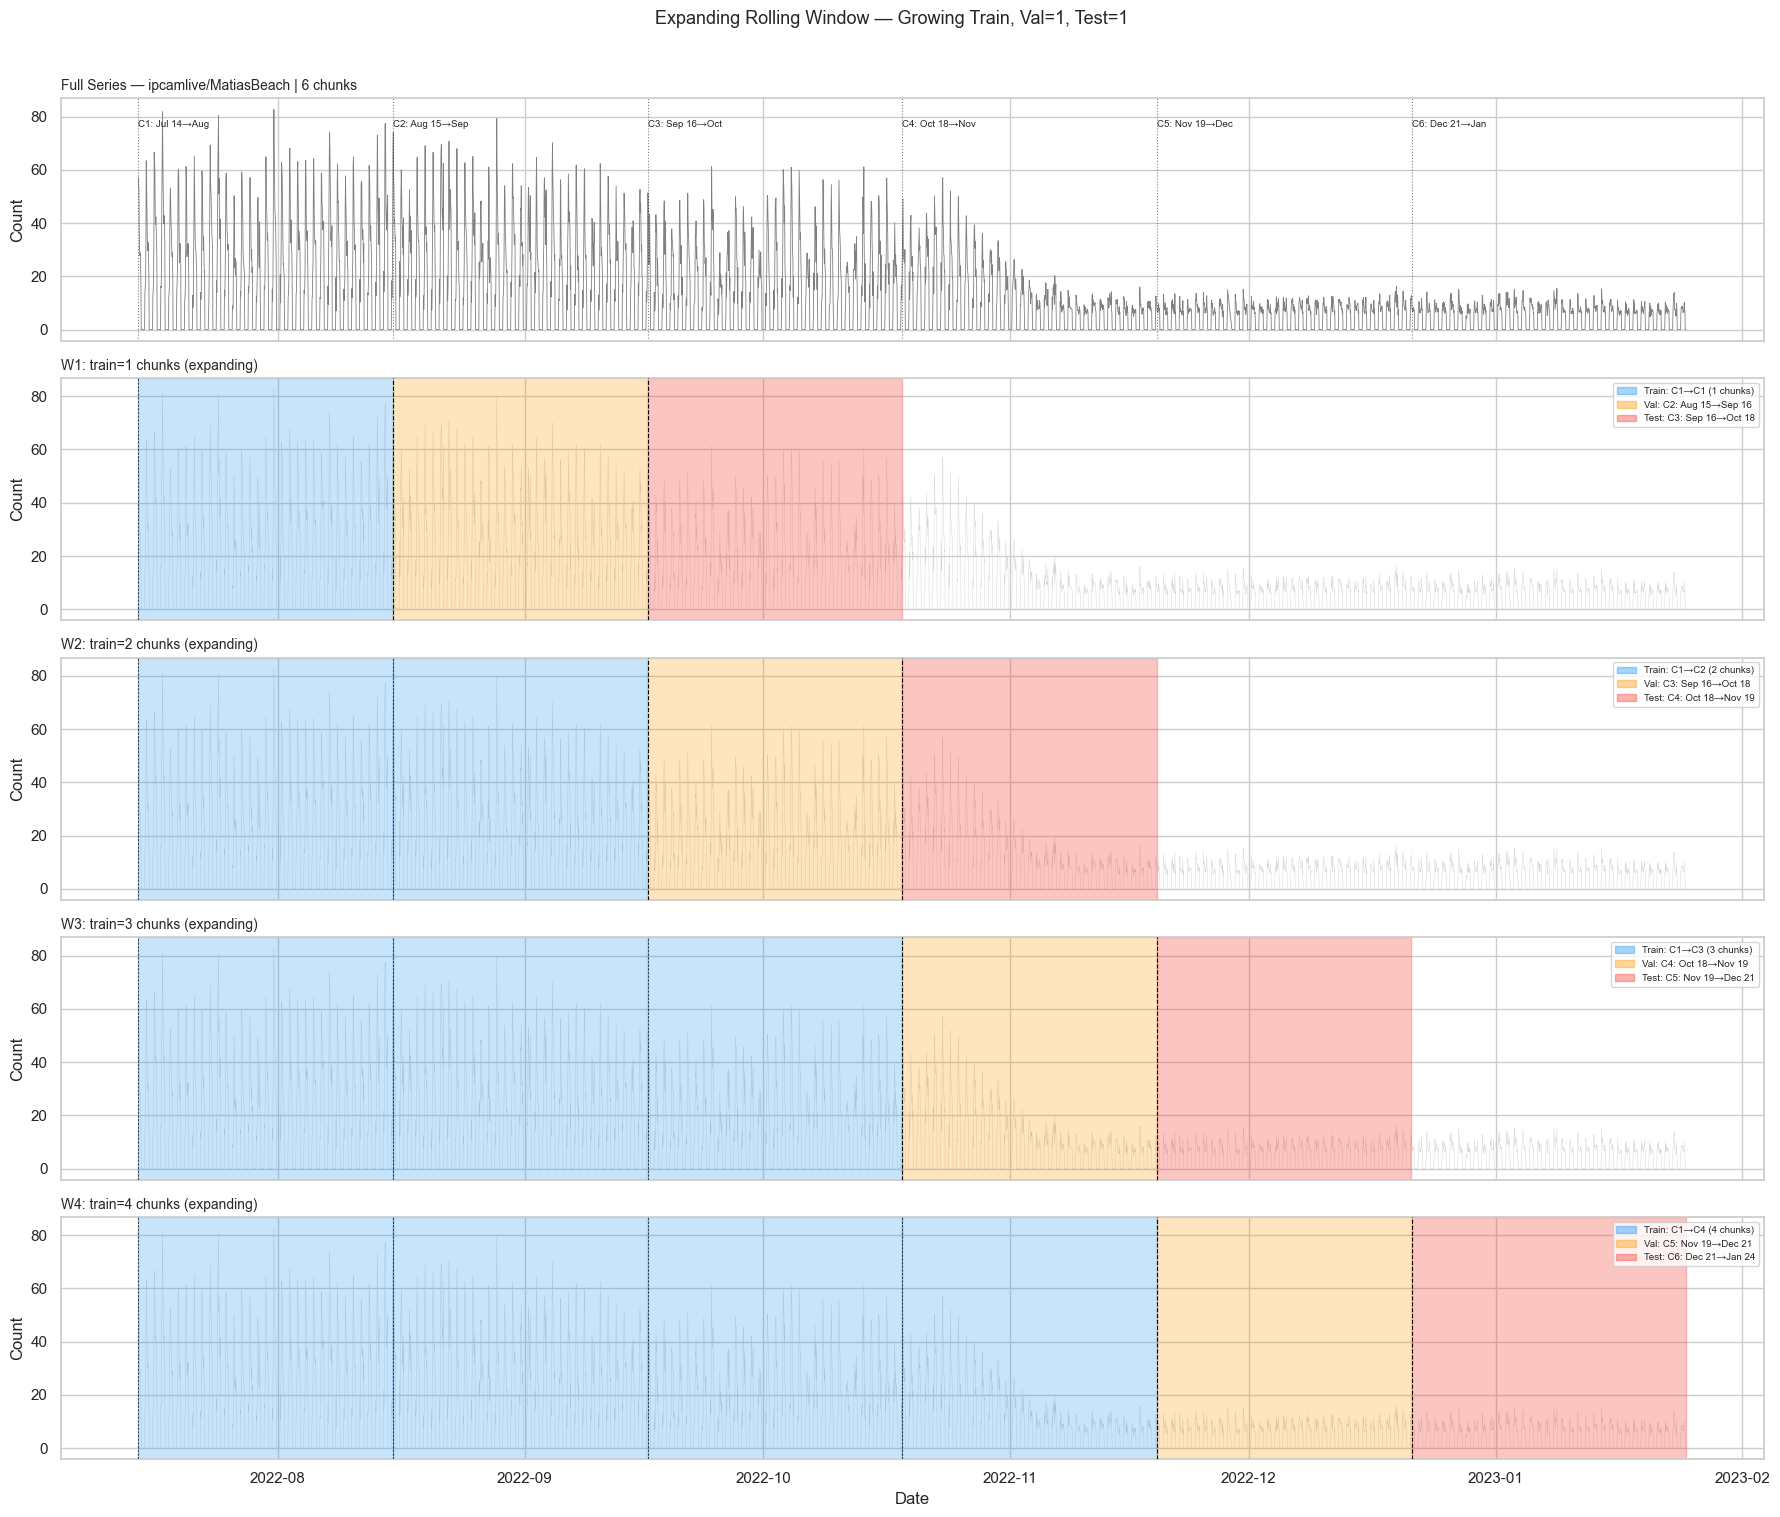

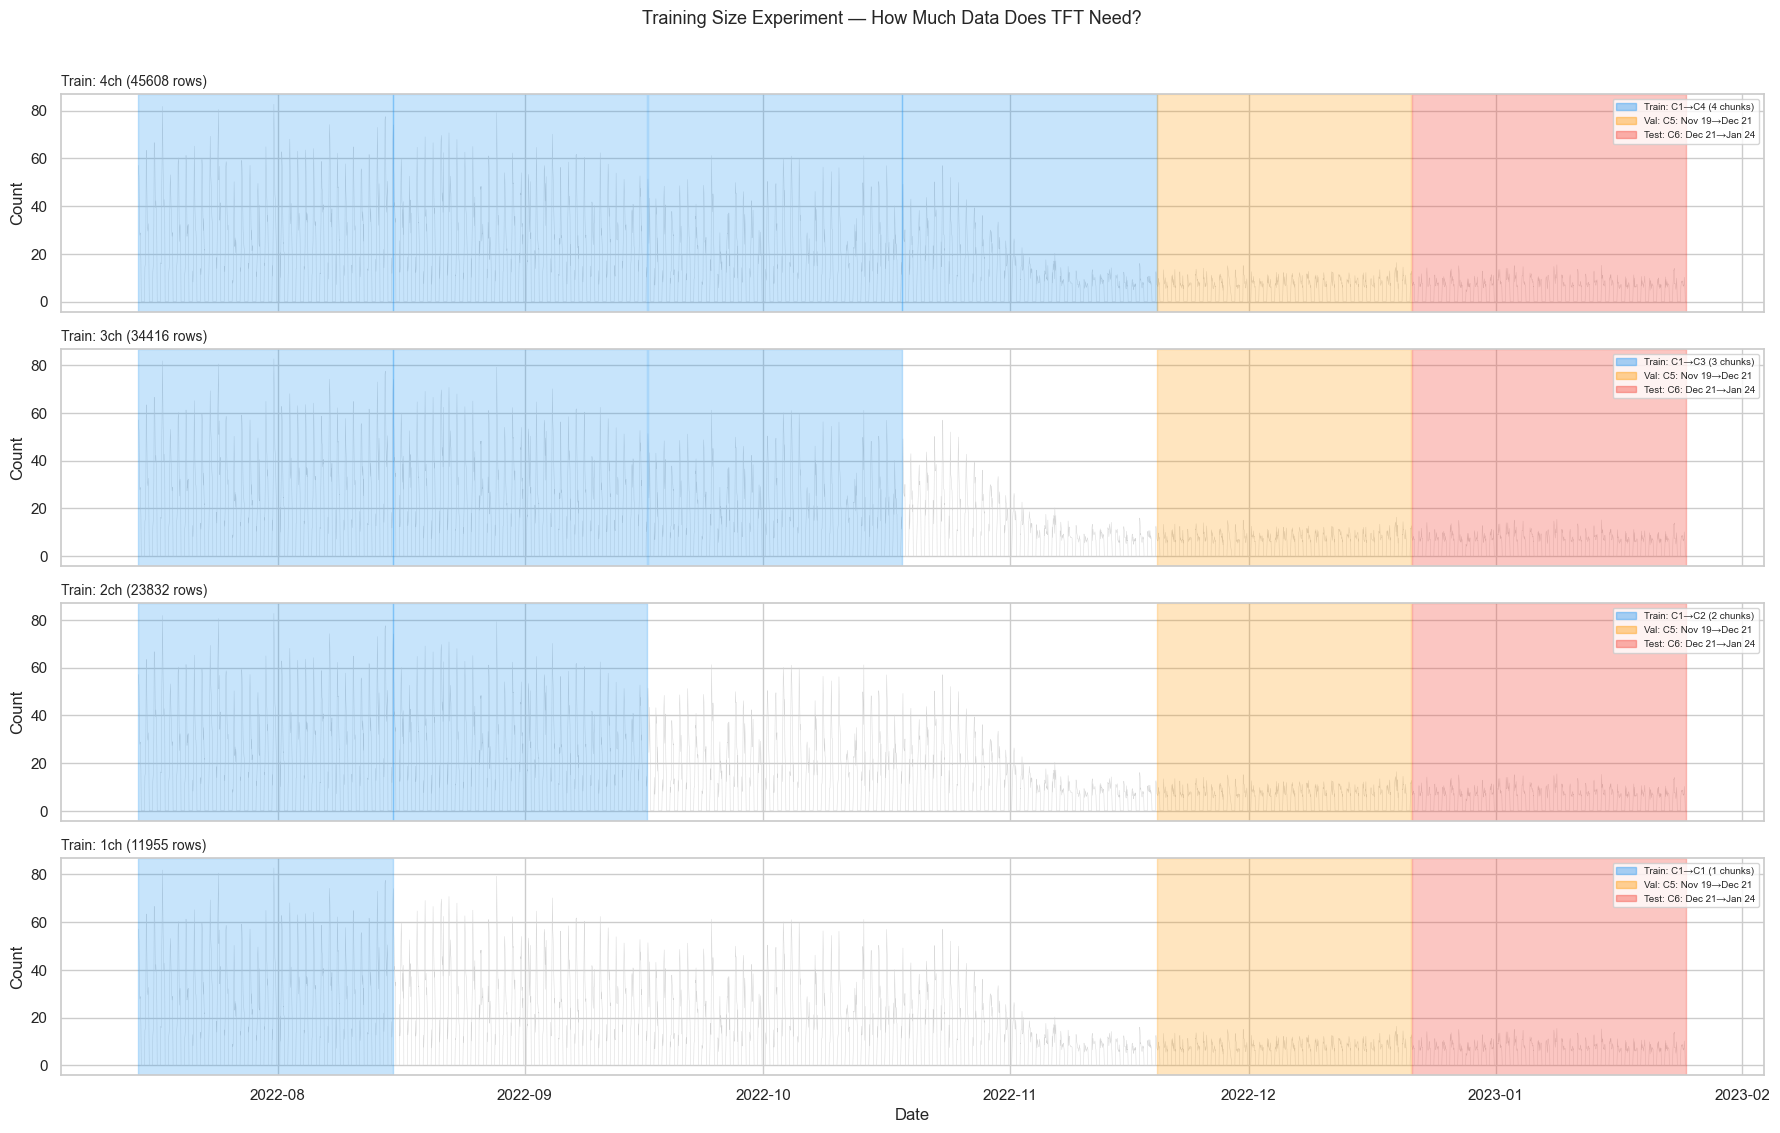

In [11]:
# === 1. SIMPLE SLIDING WINDOW (2 chunks train) ===
chunks = all_chunks['Night0']
simple_windows = simple_windows_all['Night0']
example_uid = df['beach_folder'].value_counts().idxmax()
ds_show = datasets['Night0']
example = ds_show[ds_show['beach_folder'] == example_uid].sort_values('datetime')

c_train = '#2196F3'
c_val = '#FF9800'
c_test = '#F44336'

fig, axes = plt.subplots(len(simple_windows) + 1, 1,
                         figsize=(18, 3 * (len(simple_windows) + 1)), sharex=True)
axes[0].plot(example['datetime'], example['count'], linewidth=0.6, color='gray')
for c in chunks:
    axes[0].axvline(c['start'], color='black', linestyle=':', linewidth=0.8, alpha=0.5)
    axes[0].text(c['start'], example['count'].max() * 0.95, c['label'][:15], fontsize=7, va='top')
axes[0].set_title(f'Full Series \u2014 {example_uid[:40]} | {N_CHUNKS} chunks', fontsize=10, loc='left')
axes[0].set_ylabel('Count')

for w_idx, w in enumerate(simple_windows):
    ax = axes[w_idx + 1]
    ax.plot(example['datetime'], example['count'], linewidth=0.3, color='lightgray', zorder=1)
    for tc in w['train_chunks']:
        ax.axvspan(tc['start'], tc['end'], alpha=0.25, color=c_train, zorder=2)
    val_chunk = chunks[w_idx + 2]
    test_chunk = chunks[w_idx + 3]
    ax.axvspan(val_chunk['start'], val_chunk['end'], alpha=0.25, color=c_val, zorder=2)
    ax.axvspan(test_chunk['start'], test_chunk['end'], alpha=0.3, color=c_test, zorder=2)
    t_patch = mpatches.Patch(color=c_train, alpha=0.4, label=f"Train: {w['train_label']}")
    v_patch = mpatches.Patch(color=c_val, alpha=0.4, label=f"Val: {w['val_label']}")
    te_patch = mpatches.Patch(color=c_test, alpha=0.4, label=f"Test: {w['test_label']}")
    ax.legend(handles=[t_patch, v_patch, te_patch], loc='upper right', fontsize=7)
    ax.set_ylabel('Count')
    ax.set_title(f"{w['name']}: {w['train_label']} \u2192 val \u2192 test", fontsize=10, loc='left')
axes[-1].set_xlabel('Date')
plt.suptitle('Simple Sliding Window \u2014 Train=2 Chunks, Val=1, Test=1', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# === 2. EXPANDING ROLLING WINDOW ===
rw = rolling_windows['Night0']
fig, axes = plt.subplots(len(rw) + 1, 1, figsize=(18, 3 * (len(rw) + 1)), sharex=True)
axes[0].plot(example['datetime'], example['count'], linewidth=0.6, color='gray')
for c in chunks:
    axes[0].axvline(c['start'], color='black', linestyle=':', linewidth=0.8, alpha=0.5)
    axes[0].text(c['start'], example['count'].max() * 0.95, c['label'][:15], fontsize=7, va='top')
axes[0].set_title(f'Full Series \u2014 {example_uid[:40]}', fontsize=10, loc='left')
axes[0].set_ylabel('Count')

for w_idx, w in enumerate(rw):
    ax = axes[w_idx + 1]
    ax.plot(example['datetime'], example['count'], linewidth=0.3, color='lightgray', zorder=1)
    for tc in w['train_chunks']:
        ax.axvspan(tc['start'], tc['end'], alpha=0.25, color=c_train, zorder=2)
    val_chunk = chunks[[i for i, c in enumerate(chunks) if c['label'] == w['val_label']][0]]
    test_chunk = chunks[[i for i, c in enumerate(chunks) if c['label'] == w['test_label']][0]]
    ax.axvspan(val_chunk['start'], val_chunk['end'], alpha=0.25, color=c_val, zorder=2)
    ax.axvspan(test_chunk['start'], test_chunk['end'], alpha=0.3, color=c_test, zorder=2)
    t_patch = mpatches.Patch(color=c_train, alpha=0.4, label=f"Train: {w['train_label']}")
    v_patch = mpatches.Patch(color=c_val, alpha=0.4, label=f"Val: {w['val_label']}")
    te_patch = mpatches.Patch(color=c_test, alpha=0.4, label=f"Test: {w['test_label']}")
    ax.legend(handles=[t_patch, v_patch, te_patch], loc='upper right', fontsize=7)
    ax.set_ylabel('Count')
    ax.set_title(f"{w['name']}: train={len(w['train_chunks'])} chunks (expanding)", fontsize=10, loc='left')
axes[-1].set_xlabel('Date')
plt.suptitle('Expanding Rolling Window', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# === 3. SPLIT-GAP VISUALIZATION ===
sg = split_gap_windows['Night0']
c_gap = '#9E9E9E'
fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)
axes[0].plot(example['datetime'], example['count'], linewidth=0.6, color='gray')
axes[0].axvspan(sg['gap_start'], sg['gap_end'], alpha=0.3, color=c_gap, zorder=2)
axes[0].text(sg['gap_start'] + (sg['gap_end'] - sg['gap_start'])/2, example['count'].max() * 0.9,
            'GAP (20%)', ha='center', fontsize=9, fontweight='bold', color='gray')
axes[0].set_title('Full Series \u2014 Split-Gap Layout', fontsize=10, loc='left')
axes[0].set_ylabel('Count')

for ax_idx, (label, key) in enumerate(zip(['Early Only', 'Late Only', 'Combined'], ['early', 'late', 'combined'])):
    ax = axes[ax_idx + 1]
    ax.plot(example['datetime'], example['count'], linewidth=0.3, color='lightgray', zorder=1)
    ax.axvspan(sg['gap_start'], sg['gap_end'], alpha=0.15, color=c_gap, zorder=2)
    exp = sg[key]
    tr, va, te = exp['train_data'], exp['val_data'], exp['test_data']
    ax.axvspan(tr['datetime'].min(), tr['datetime'].max(), alpha=0.25, color=c_train, zorder=3)
    ax.axvspan(va['datetime'].min(), va['datetime'].max(), alpha=0.25, color=c_val, zorder=3)
    ax.axvspan(te['datetime'].min(), te['datetime'].max(), alpha=0.3, color=c_test, zorder=3)
    t_patch = mpatches.Patch(color=c_train, alpha=0.4, label=f"Train ({len(tr)} rows)")
    v_patch = mpatches.Patch(color=c_val, alpha=0.4, label=f"Val ({len(va)} rows)")
    te_patch = mpatches.Patch(color=c_test, alpha=0.4, label=f"Test ({len(te)} rows)")
    g_patch = mpatches.Patch(color=c_gap, alpha=0.3, label='Gap (20%)')
    ax.legend(handles=[t_patch, v_patch, te_patch, g_patch], loc='upper right', fontsize=7)
    ax.set_ylabel('Count')
    ax.set_title(label, fontsize=10, loc='left')
axes[-1].set_xlabel('Date')
plt.suptitle('Split-Gap \u2014 Simulating Disconnected Periods (2022 + 2025)', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()


## TFT — Sliding Window Experiments

For each dataset strategy, train TFT on chunk *i*, validate on chunk *i+1*, test on chunk *i+2*.

In [ ]:
all_results = []
all_cv_details = []

def run_tft_experiment(exp_name, exp_type, ds_name, train_data, val_data, test_data,
                       train_label, val_label, test_label):
    nf_train = prepare_nf_data(train_data)
    nf_val = prepare_nf_data(val_data)
    nf_test = prepare_nf_data(test_data)

    common_ids = (set(nf_train['unique_id'].unique()) &
                  set(nf_val['unique_id'].unique()) &
                  set(nf_test['unique_id'].unique()))
    if len(common_ids) == 0:
        print(f"  {exp_name}: no common series, skipping")
        return

    nf_train = nf_train[nf_train['unique_id'].isin(common_ids)].reset_index(drop=True)
    nf_val = nf_val[nf_val['unique_id'].isin(common_ids)].reset_index(drop=True)
    nf_test = nf_test[nf_test['unique_id'].isin(common_ids)].reset_index(drop=True)

    nf_all = pd.concat([nf_train, nf_val, nf_test]).sort_values(['unique_id', 'ds']).reset_index(drop=True)
    nf_all = nf_all.drop_duplicates(subset=['unique_id', 'ds'], keep='last').reset_index(drop=True)

    test_horizon = nf_test.groupby('unique_id').size().min()
    horizon = min(HORIZON, test_horizon)

    print(f"\n  {exp_name} | h={horizon} | series={len(common_ids)}")
    print(f"    Train: {train_label} ({len(train_data)} rows)")
    print(f"    Val:   {val_label} | Test: {test_label}")

    try:
        t0 = time.time()
        model = TFT(
            h=horizon, input_size=INPUT_SIZE, hidden_size=64, n_head=4,
            max_steps=MAX_STEPS, early_stop_patience_steps=-1,
            learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE,
            scaler_type='robust', random_seed=42,
            accelerator=ACCELERATOR, devices=DEVICES,
            loss=MAE(), hist_exog_list=ALL_FEATURES, val_check_steps=50,
        )
        nf = NeuralForecast(models=[model], freq='h')
        cv_results = nf.cross_validation(df=nf_all, n_windows=1, step_size=horizon)
        elapsed = time.time() - t0

        pred_col = [c for c in cv_results.columns if c not in ['unique_id', 'ds', 'cutoff', 'y']][0]
        cv_results['pred'] = np.clip(cv_results[pred_col].values, 0, None)
        cv_results['hour'] = cv_results['ds'].dt.hour
        cv_results['is_night'] = ((cv_results['hour'] >= NIGHT_START) | (cv_results['hour'] <= NIGHT_END)).astype(int)

        m_full = calc_metrics(cv_results['y'].values, cv_results['pred'].values, cv_results['y'].max())
        day_mask = cv_results['is_night'] == 0
        m_day = calc_metrics(cv_results.loc[day_mask, 'y'].values,
                             cv_results.loc[day_mask, 'pred'].values,
                             cv_results.loc[day_mask, 'y'].max()) if day_mask.sum() > 10 else m_full

        beach_results = []
        for b in cv_results['unique_id'].unique():
            bmask = (cv_results['unique_id'] == b) & day_mask
            if bmask.sum() < 3:
                continue
            yt = cv_results.loc[bmask, 'y'].values
            yp = cv_results.loc[bmask, 'pred'].values
            bm = calc_metrics(yt, yp, yt.max())
            bm['beach'] = b
            bm['max_count'] = yt.max()
            beach_results.append(bm)

        beach_df = pd.DataFrame(beach_results)
        avg_rel_day = beach_df['RelMAE'].mean() if len(beach_df) > 0 else np.nan

        all_results.append({
            'Model': 'NF_TFT', 'Dataset': ds_name, 'Experiment': exp_type,
            'Window': exp_name,
            'MAE': m_full['MAE'], 'RMSE': m_full['RMSE'], 'R2': m_full['R2'],
            'AvgRelMAE': m_full['RelMAE'],
            'MAE_day': m_day['MAE'], 'R2_day': m_day['R2'], 'AvgRelMAE_day': avg_rel_day,
            'Time': elapsed,
            'train_period': train_label, 'val_period': val_label, 'test_period': test_label,
            'train_rows': len(train_data),
        })
        all_cv_details.append({
            'ds_name': ds_name, 'exp_type': exp_type, 'window': exp_name,
            'model': 'NF_TFT',
            'merged': cv_results[['unique_id', 'ds', 'y', 'pred', 'hour', 'is_night']].copy(),
            'pred_col': 'pred', 'beach_df': beach_df,
        })
        print(f"    {elapsed:.0f}s | MAE={m_full['MAE']:.1f} (day={m_day['MAE']:.1f}) | "
              f"RelMAE_day={avg_rel_day:.1f}% | R2={m_full['R2']:.3f} (day={m_day['R2']:.3f})")
    except Exception as e:
        print(f"    ERROR: {e}")
        import traceback
        traceback.print_exc()

# ============================
# RUN ALL EXPERIMENT TYPES
# ============================
for ds_name in ['Full24h', 'Night0', 'NightQ1', 'NightMin']:
    chunks = all_chunks[ds_name]

    print(f"\n{'#' * 70}")
    print(f"# SIMPLE SLIDING \u2014 {ds_name}")
    print(f"{'#' * 70}")
    for w in simple_windows_all[ds_name]:
        run_tft_experiment(
            exp_name=w['name'], exp_type="Simple", ds_name=ds_name,
            train_data=w['train_data'], val_data=w['val_data'], test_data=w['test_data'],
            train_label=w['train_label'], val_label=w['val_label'], test_label=w['test_label'],
        )

    print(f"\n{'#' * 70}")
    print(f"# EXPANDING ROLLING \u2014 {ds_name}")
    print(f"{'#' * 70}")
    for w in rolling_windows[ds_name]:
        run_tft_experiment(
            exp_name=w['name'], exp_type="Expanding", ds_name=ds_name,
            train_data=w['train_data'], val_data=w['val_data'], test_data=w['test_data'],
            train_label=w['train_label'], val_label=w['val_label'], test_label=w['test_label'],
        )

    print(f"\n{'#' * 70}")
    print(f"# SPLIT-GAP \u2014 {ds_name}")
    print(f"{'#' * 70}")
    sg = split_gap_windows[ds_name]
    for key, label in [('early', 'SG_Early'), ('late', 'SG_Late'), ('combined', 'SG_Combined')]:
        exp = sg[key]
        run_tft_experiment(
            exp_name=label, exp_type="SplitGap", ds_name=ds_name,
            train_data=exp['train_data'], val_data=exp['val_data'], test_data=exp['test_data'],
            train_label=exp['train_label'], val_label=exp['val_label'], test_label=exp['test_label'],
        )



######################################################################
# SIMPLE SLIDING — Full24h
######################################################################


Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  SW1 | h=168 | val=503 | series=16
    Train: C1+C2 (2 chunks) (23832 rows)
    Val:   C3: Sep 16→Oct 18 | Test: C4: Oct 18→Nov 19



  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 4.7 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 977 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.187     Total estimated model params size (MB)
368       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …


Detected KeyboardInterrupt, attempting graceful shutdown ...


    ERROR: name 'exit' is not defined


Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/call.py", line 48, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/trainer.py", line 599, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/trainer.py", line 1012, in _run
    results = self._run_stage()
  File "/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/trainer.py", line 1056, in _run_stage
    self.fit_loop.run()
    ~~~~~~~~~~~~~~~~~^^
  File "/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py", line 216, in run
    self.advance()
    ~~~~~~~~~~~~^^
  File "/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py", line 455, in advance
    self.epoch_loop.run(self._dat


  SW2 | h=168 | val=553 | series=16
    Train: C2+C3 (2 chunks) (22461 rows)
    Val:   C4: Oct 18→Nov 19 | Test: C5: Nov 19→Dec 21


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

## Results

In [ ]:
results_df = pd.DataFrame(all_results)

save_dir = Path(SAVE_DIR)
save_dir.mkdir(parents=True, exist_ok=True)
results_df.to_csv(save_dir / 'tft_chunk_results.csv', index=False)

print("=" * 70)
print("ALL RESULTS (NeuralForecast TFT)")
print("=" * 70)
cols = ['Model', 'Dataset', 'Experiment', 'Window', 'train_rows', 'MAE', 'MAE_day', 'R2', 'R2_day', 'AvgRelMAE_day', 'Time']
cols = [c for c in cols if c in results_df.columns]
print(results_df[cols].to_string(index=False))


In [ ]:
for exp_type in results_df['Experiment'].unique():
    sub = results_df[results_df['Experiment'] == exp_type]
    print(f"\n{'=' * 60}")
    print(f"{exp_type} — AvgRelMAE (%)")
    print(f"{'=' * 60}")
    pivot = sub.pivot_table(index='Dataset', columns='Window', values='AvgRelMAE')
    print(pivot.round(1).to_string())

    print(f"\n{exp_type} — R²")
    pivot_r2 = sub.pivot_table(index='Dataset', columns='Window', values='R2')
    print(pivot_r2.round(3).to_string())

### Experiment Comparison

In [ ]:
if len(results_df) > 0:
    metric_col = 'AvgRelMAE_day' if 'AvgRelMAE_day' in results_df.columns else 'AvgRelMAE'
    r2_col = 'R2_day' if 'R2_day' in results_df.columns else 'R2'

    exp_types = results_df['Experiment'].unique()
    n_exp = len(exp_types)
    fig, axes = plt.subplots(n_exp, 2, figsize=(16, 5 * n_exp))
    if n_exp == 1:
        axes = axes.reshape(1, -1)
    for row, exp_type in enumerate(exp_types):
        sub = results_df[results_df['Experiment'] == exp_type]
        pivot = sub.pivot_table(index='Dataset', columns='Window', values=metric_col)
        pivot.plot(kind='bar', ax=axes[row, 0], width=0.7, colormap='Set2')
        axes[row, 0].set_ylabel('AvgRelMAE_day (%)')
        axes[row, 0].set_title(f'{exp_type} \u2014 RelMAE daytime (lower is better)')
        axes[row, 0].tick_params(axis='x', rotation=30)
        axes[row, 0].legend(title='Window', fontsize=7)
        pivot_r2 = sub.pivot_table(index='Dataset', columns='Window', values=r2_col)
        pivot_r2.plot(kind='bar', ax=axes[row, 1], width=0.7, colormap='Set2')
        axes[row, 1].set_ylabel('R\u00b2 (day)')
        axes[row, 1].set_title(f'{exp_type} \u2014 R\u00b2 daytime (higher is better)')
        axes[row, 1].tick_params(axis='x', rotation=30)
        axes[row, 1].legend(title='Window', fontsize=7)
    plt.tight_layout()
    plt.savefig(save_dir / 'tft_all_experiments.png', dpi=150)
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 5))
    ranking = results_df.groupby(['Dataset', 'Experiment'])[metric_col].mean().unstack()
    ranking = ranking.loc[ranking.mean(axis=1).sort_values().index]
    ranking.plot(kind='barh', ax=ax, width=0.7)
    ax.set_xlabel('Mean AvgRelMAE_day (%)')
    ax.set_title('Dataset Strategy Ranking by Experiment Type (Daytime Only)')
    ax.legend(title='Experiment')
    plt.tight_layout()
    plt.savefig(save_dir / 'tft_dataset_ranking.png', dpi=150)
    plt.show()


### Predictions vs Actual — Best Window

In [ ]:
if len(all_cv_details) > 0:
    metric_col = 'AvgRelMAE_day' if 'AvgRelMAE_day' in results_df.columns else 'AvgRelMAE'
    best_idx = results_df[metric_col].idxmin()
    best_row = results_df.iloc[best_idx]
    best_detail = all_cv_details[best_idx]
    merged = best_detail['merged']

    beaches = merged.groupby('unique_id').size().nlargest(6).index.tolist()
    n_show = len(beaches)
    fig, axes = plt.subplots(n_show, 1, figsize=(16, 3 * n_show), sharex=False)
    if n_show == 1:
        axes = [axes]

    for ax, beach in zip(axes, beaches):
        sub = merged[merged['unique_id'] == beach].sort_values('ds')
        ax.plot(sub['ds'], sub['y'], label='Actual', color='steelblue', linewidth=1)
        ax.plot(sub['ds'], sub['pred'], label='Predicted', color='coral', linewidth=1, alpha=0.8)
        for _, row in sub[sub['is_night'] == 1].iterrows():
            ax.axvspan(row['ds'] - pd.Timedelta(minutes=30),
                       row['ds'] + pd.Timedelta(minutes=30), alpha=0.06, color='navy', zorder=0)
        day_sub = sub[sub['is_night'] == 0]
        mae_d = np.abs(day_sub['y'] - day_sub['pred']).mean() if len(day_sub) > 0 else 0
        r2_d = r2_score(day_sub['y'], day_sub['pred']) if len(day_sub) > 3 else 0
        ax.set_title(f'{beach[:35]} | Day MAE={mae_d:.1f} | Day R\u00b2={r2_d:.3f}', fontsize=9, loc='left')
        handles = ax.get_legend_handles_labels()[0] + [mpatches.Patch(color='navy', alpha=0.15, label='Night')]
        lbls = ax.get_legend_handles_labels()[1] + ['Night']
        ax.legend(handles, lbls, loc='upper right', fontsize=7)
        ax.set_ylabel('Count')

    axes[-1].set_xlabel('Date')
    plt.suptitle(f"Best NF_TFT: {best_row['Dataset']} {best_row['Window']} | "
                 f"Day RelMAE={best_row.get('AvgRelMAE_day', best_row['AvgRelMAE']):.1f}%", fontsize=13, y=1.01)
    plt.tight_layout()
    plt.savefig(save_dir / 'tft_predictions_best.png', dpi=150)
    plt.show()


### Error Analysis

In [ ]:
if len(all_cv_details) > 0:
    metric_col = 'AvgRelMAE_day' if 'AvgRelMAE_day' in results_df.columns else 'AvgRelMAE'
    best_idx = results_df[metric_col].idxmin()
    best_detail = all_cv_details[best_idx]
    merged = best_detail['merged']

    merged['abs_err'] = np.abs(merged['y'] - merged['pred'])
    errors = merged['y'].values - merged['pred'].values

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes[0,0].hist(errors, bins=80, color='steelblue', alpha=0.7, edgecolor='white')
    axes[0,0].axvline(0, color='red', linestyle='--')
    axes[0,0].axvline(errors.mean(), color='orange', linestyle='--', label=f'Bias={errors.mean():.1f}')
    axes[0,0].set_xlabel('Error')
    axes[0,0].set_title('Error Distribution')
    axes[0,0].legend()

    axes[0,1].scatter(merged['y'], merged['pred'], s=2, alpha=0.3, color='steelblue')
    mx = max(merged['y'].max(), merged['pred'].max())
    axes[0,1].plot([0, mx], [0, mx], 'r--', linewidth=1)
    axes[0,1].set_xlabel('Actual')
    axes[0,1].set_ylabel('Predicted')
    axes[0,1].set_title('Actual vs Predicted')

    hourly = merged.groupby('hour')['abs_err'].mean()
    colors = ['navy' if (h >= NIGHT_START or h <= NIGHT_END) else 'steelblue' for h in hourly.index]
    axes[1,0].bar(hourly.index, hourly.values, color=colors, alpha=0.7)
    axes[1,0].set_xlabel('Hour')
    axes[1,0].set_ylabel('MAE')
    axes[1,0].set_title('MAE by Hour (dark=night)')

    day_err = merged[merged['is_night'] == 0]['abs_err']
    night_err = merged[merged['is_night'] == 1]['abs_err']
    bp = axes[1,1].boxplot([day_err, night_err], labels=['Day', 'Night'], patch_artist=True)
    bp['boxes'][0].set_facecolor('steelblue')
    bp['boxes'][1].set_facecolor('navy')
    for box in bp['boxes']:
        box.set_alpha(0.5)
    axes[1,1].set_ylabel('Absolute Error')
    axes[1,1].set_title(f'Day MAE={day_err.mean():.1f} vs Night MAE={night_err.mean():.1f}')

    plt.suptitle('Error Analysis \u2014 Best NF_TFT Window', fontsize=13, y=1.01)
    plt.tight_layout()
    plt.savefig(save_dir / 'tft_error_analysis.png', dpi=150)
    plt.show()

    print(f"Day MAE: {day_err.mean():.1f} | Night MAE: {night_err.mean():.1f}")
    print(f"Night is {night_err.mean()/day_err.mean():.1f}x {'lower' if night_err.mean() < day_err.mean() else 'higher'} than day")


### Summary

In [ ]:
print("=" * 70)
print("FINAL SUMMARY \u2014 NeuralForecast TFT")
print("=" * 70)

metric_col = 'AvgRelMAE_day' if 'AvgRelMAE_day' in results_df.columns else 'AvgRelMAE'
r2_col = 'R2_day' if 'R2_day' in results_df.columns else 'R2'

print("\n--- Best per Experiment Type (daytime metrics) ---")
for exp_type in results_df['Experiment'].unique():
    sub = results_df[results_df['Experiment'] == exp_type]
    best = sub.loc[sub[metric_col].idxmin()]
    print(f"  {exp_type:12s} | {best['Dataset']:10s} | {best['Window']} "
          f"| RelMAE_day={best[metric_col]:.1f}% | R2_day={best[r2_col]:.3f}")

print("\n--- Best per Dataset ---")
for ds in results_df['Dataset'].unique():
    sub = results_df[results_df['Dataset'] == ds]
    best = sub.loc[sub[metric_col].idxmin()]
    print(f"  {ds:10s} | {best['Experiment']:12s} {best['Window']} "
          f"| RelMAE_day={best[metric_col]:.1f}% | R2_day={best[r2_col]:.3f}")

print("\n--- Stability (CV% across windows) ---")
for exp_type in results_df['Experiment'].unique():
    sub = results_df[results_df['Experiment'] == exp_type]
    stab = sub.groupby('Dataset')[metric_col].agg(['mean', 'std'])
    stab['cv%'] = (stab['std'] / stab['mean'] * 100).round(1)
    print(f"\n  {exp_type}:")
    print(stab.sort_values('mean').round(1).to_string())

overall = results_df.loc[results_df[metric_col].idxmin()]
print(f"\n{'=' * 70}")
print(f"OVERALL BEST NF_TFT: {overall['Experiment']} | {overall['Dataset']} | {overall['Window']}")
print(f"  RelMAE_day={overall[metric_col]:.1f}% | R2_day={overall[r2_col]:.3f} | MAE={overall['MAE']:.1f}")
print(f"{'=' * 70}")


---
## PyTorch-Forecasting TFT (Daytime Only)

Uses `TimeSeriesDataSet` with integer `time_idx` to handle daytime-only data without gaps.
This avoids the night bias problem entirely — no fake interpolation, no night=0 tricks.

Same experiment structure: Simple Sliding, Expanding Rolling, Split-Gap.

In [ ]:
import subprocess, sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "pytorch-forecasting", "-q"])

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE as PF_MAE, QuantileLoss

print("pytorch-forecasting imported successfully")


### Prepare Daytime Dataset for PyTorch-Forecasting

Filter to daytime hours only, then assign a sequential `time_idx` per beach.
TFT sees a continuous sequence — no gaps, no night bias.

In [ ]:
# Daytime only — no night hours at all
df_day = df[df['is_night'] == 0].copy()
df_day = df_day.sort_values(['beach_folder', 'datetime']).reset_index(drop=True)
df_day['time_idx'] = df_day.groupby('beach_folder').cumcount()
df_day['group_id'] = df_day['beach_folder'].astype(str)

# Keep original datetime for later analysis
df_day['orig_datetime'] = df_day['datetime']

print(f"Daytime dataset: {len(df_day)} rows, {df_day['group_id'].nunique()} beaches")
print(f"Hours per beach: {df_day.groupby('group_id').size().describe()[['min', 'max', 'mean']].to_dict()}")
print(f"Time idx range: 0 to {df_day['time_idx'].max()}")


In [ ]:
# Parameters for pytorch-forecasting TFT
PF_MAX_ENCODER = 48
PF_MAX_PREDICTION = 24  # predict next 24 daytime hours
PF_BATCH_SIZE = 64
PF_MAX_EPOCHS = 50
PF_HIDDEN_SIZE = 32
PF_LR = 0.03

PF_TIME_VARYING_KNOWN = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_summer']
PF_TIME_VARYING_UNKNOWN = ['count'] + WEATHER_COLS

pf_results = []
pf_cv_details = []


In [ ]:
def run_pf_experiment(exp_name, exp_type, ds_name, train_df, val_df, test_df,
                      train_label, val_label, test_label):
    common_ids = (set(train_df['group_id'].unique()) &
                  set(val_df['group_id'].unique()) &
                  set(test_df['group_id'].unique()))
    if len(common_ids) == 0:
        print(f"  {exp_name}: no common series, skipping")
        return

    train_df = train_df[train_df['group_id'].isin(common_ids)].copy()
    val_df = val_df[val_df['group_id'].isin(common_ids)].copy()
    test_df = test_df[test_df['group_id'].isin(common_ids)].copy()

    # Rebuild continuous time_idx across train+val+test
    combined = pd.concat([train_df, val_df, test_df]).sort_values(['group_id', 'datetime']).reset_index(drop=True)
    combined['time_idx'] = combined.groupby('group_id').cumcount()

    n_per_group = combined.groupby('group_id').size()
    train_cutoff = combined[combined['datetime'] <= train_df['datetime'].max()]['time_idx'].max()
    val_cutoff = combined[combined['datetime'] <= val_df['datetime'].max()]['time_idx'].max()

    known_reals = [c for c in PF_TIME_VARYING_KNOWN if c in combined.columns]
    unknown_reals = [c for c in PF_TIME_VARYING_UNKNOWN if c in combined.columns]

    print(f"\n  {exp_name} | series={len(common_ids)} | encoder={PF_MAX_ENCODER} | horizon={PF_MAX_PREDICTION}")
    print(f"    Train: {train_label} | Val: {val_label} | Test: {test_label}")

    try:
        training_ds = TimeSeriesDataSet(
            combined[combined['time_idx'] <= val_cutoff],
            time_idx='time_idx',
            target='count',
            group_ids=['group_id'],
            min_encoder_length=PF_MAX_ENCODER // 2,
            max_encoder_length=PF_MAX_ENCODER,
            min_prediction_length=1,
            max_prediction_length=PF_MAX_PREDICTION,
            time_varying_known_reals=['time_idx'] + known_reals,
            time_varying_unknown_reals=unknown_reals,
            target_normalizer=GroupNormalizer(groups=['group_id'], transformation='softplus'),
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
        )

        validation_ds = TimeSeriesDataSet.from_dataset(
            training_ds, combined[combined['time_idx'] <= val_cutoff],
            predict=True, stop_randomization=True
        )

        test_ds = TimeSeriesDataSet.from_dataset(
            training_ds, combined,
            predict=True, stop_randomization=True
        )

        train_dl = training_ds.to_dataloader(train=True, batch_size=PF_BATCH_SIZE, num_workers=0)
        val_dl = validation_ds.to_dataloader(train=False, batch_size=PF_BATCH_SIZE * 4, num_workers=0)
        test_dl = test_ds.to_dataloader(train=False, batch_size=PF_BATCH_SIZE * 4, num_workers=0)

        t0 = time.time()
        early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, mode='min')

        trainer = pl.Trainer(
            max_epochs=PF_MAX_EPOCHS,
            accelerator=ACCELERATOR if ACCELERATOR != 'gpu' else 'auto',
            devices=DEVICES,
            gradient_clip_val=0.1,
            callbacks=[early_stop],
            enable_model_summary=False,
            enable_progress_bar=True,
        )

        tft = TemporalFusionTransformer.from_dataset(
            training_ds,
            learning_rate=PF_LR,
            hidden_size=PF_HIDDEN_SIZE,
            attention_head_size=2,
            dropout=0.1,
            hidden_continuous_size=PF_HIDDEN_SIZE,
            loss=QuantileLoss(),
            optimizer='ranger',
            reduce_on_plateau_patience=4,
        )

        trainer.fit(tft, train_dataloaders=train_dl, val_dataloaders=val_dl)
        elapsed = time.time() - t0

        predictions = tft.predict(test_dl, return_y=True, trainer_kwargs=dict(accelerator='cpu'))
        y_pred = predictions.output.cpu().numpy().mean(axis=-1).flatten()
        y_true = predictions.y[0].cpu().numpy().flatten()
        y_pred = np.clip(y_pred, 0, None)

        m = calc_metrics(y_true, y_pred, y_true.max())

        pf_results.append({
            'Model': 'PF_TFT', 'Dataset': ds_name, 'Experiment': exp_type,
            'Window': exp_name,
            'MAE': m['MAE'], 'RMSE': m['RMSE'], 'R2': m['R2'],
            'AvgRelMAE_day': m['RelMAE'],
            'Time': elapsed,
            'train_period': train_label, 'val_period': val_label, 'test_period': test_label,
            'train_rows': len(train_df),
        })

        pf_cv_details.append({
            'ds_name': ds_name, 'exp_type': exp_type, 'window': exp_name,
            'model': 'PF_TFT', 'y_true': y_true, 'y_pred': y_pred,
        })
        print(f"    {elapsed:.0f}s | MAE={m['MAE']:.1f} | RelMAE={m['RelMAE']:.1f}% | R2={m['R2']:.3f}")

    except Exception as e:
        print(f"    ERROR: {e}")
        import traceback
        traceback.print_exc()


### Run PyTorch-Forecasting TFT Experiments

Uses the **Daytime** dataset only (no night hours). Same 3 experiment types as NeuralForecast.

In [ ]:
# Build experiments for daytime dataset
ds_name = 'Daytime'
ds_day = datasets['Daytime']

chunks_day, _ = create_temporal_chunks(ds_day, N_CHUNKS)
all_chunks['Daytime'] = chunks_day

# Simple sliding
sw_day = []
for i in range(len(chunks_day) - 3):
    train_data = pd.concat([chunks_day[i]['data'], chunks_day[i+1]['data']])
    sw_day.append({
        'name': f"SW{i+1}",
        'train_data': train_data,
        'val_data': chunks_day[i+2]['data'],
        'test_data': chunks_day[i+3]['data'],
        'train_label': f"{chunks_day[i]['label'].split(':')[0]}+{chunks_day[i+1]['label'].split(':')[0]}",
        'val_label': chunks_day[i+2]['label'],
        'test_label': chunks_day[i+3]['label'],
    })

# Expanding rolling
ew_day = []
for test_idx in range(2, N_CHUNKS):
    val_idx = test_idx - 1
    train_chunks = chunks_day[:val_idx]
    ew_day.append({
        'name': f"W{len(ew_day)+1}",
        'train_data': pd.concat([c['data'] for c in train_chunks]),
        'val_data': chunks_day[val_idx]['data'],
        'test_data': chunks_day[test_idx]['data'],
        'train_label': f"{train_chunks[0]['label'].split(':')[0]}\u2192{train_chunks[-1]['label'].split(':')[0]} ({len(train_chunks)}ch)",
        'val_label': chunks_day[val_idx]['label'],
        'test_label': chunks_day[test_idx]['label'],
    })

# Split-gap
n = len(ds_day)
ds_day_sorted = ds_day.sort_values('datetime').reset_index(drop=True)
early = ds_day_sorted.iloc[:int(n * 0.4)]
late = ds_day_sorted.iloc[int(n * 0.6):]
gap_start = ds_day_sorted.iloc[int(n * 0.4)]['datetime']
gap_end = ds_day_sorted.iloc[int(n * 0.6)]['datetime']

def split_period_day(period_df, name):
    np_ = len(period_df)
    tr = period_df.iloc[:int(np_ * 0.6)]
    va = period_df.iloc[int(np_ * 0.6):int(np_ * 0.8)]
    te = period_df.iloc[int(np_ * 0.8):]
    return {
        'name': name,
        'train_data': tr, 'val_data': va, 'test_data': te,
        'train_label': f"{name} train ({tr['datetime'].min().strftime('%b %d')}\u2192{tr['datetime'].max().strftime('%b %d')})",
        'val_label': f"{name} val",
        'test_label': f"{name} test",
    }

sg_early = split_period_day(early, "Early")
sg_late = split_period_day(late, "Late")
sg_combined = {
    'name': "Combined",
    'train_data': pd.concat([sg_early['train_data'], sg_late['train_data']]),
    'val_data': sg_late['val_data'],
    'test_data': sg_late['test_data'],
    'train_label': f"Early+Late train",
    'val_label': sg_late['val_label'],
    'test_label': sg_late['test_label'],
}

sg_day = [sg_early, sg_late, sg_combined]

print(f"Daytime experiments:")
print(f"  Simple sliding: {len(sw_day)} windows")
print(f"  Expanding: {len(ew_day)} windows")
print(f"  Split-gap: 3 (Early, Late, Combined)")


In [ ]:
# Prepare daytime df with time_idx for pytorch-forecasting
def prepare_pf_data(data):
    d = data.copy()
    d = d.sort_values(['beach_folder', 'datetime']).reset_index(drop=True)
    d['group_id'] = d['beach_folder'].astype(str)
    return d

# Run simple sliding
print("=" * 70)
print("PYTORCH-FORECASTING TFT \u2014 SIMPLE SLIDING (Daytime)")
print("=" * 70)
for w in sw_day:
    run_pf_experiment(
        exp_name=w['name'], exp_type="Simple", ds_name="Daytime",
        train_df=prepare_pf_data(w['train_data']),
        val_df=prepare_pf_data(w['val_data']),
        test_df=prepare_pf_data(w['test_data']),
        train_label=w['train_label'], val_label=w['val_label'], test_label=w['test_label'],
    )

# Run expanding rolling
print("\n" + "=" * 70)
print("PYTORCH-FORECASTING TFT \u2014 EXPANDING ROLLING (Daytime)")
print("=" * 70)
for w in ew_day:
    run_pf_experiment(
        exp_name=w['name'], exp_type="Expanding", ds_name="Daytime",
        train_df=prepare_pf_data(w['train_data']),
        val_df=prepare_pf_data(w['val_data']),
        test_df=prepare_pf_data(w['test_data']),
        train_label=w['train_label'], val_label=w['val_label'], test_label=w['test_label'],
    )

# Run split-gap
print("\n" + "=" * 70)
print("PYTORCH-FORECASTING TFT \u2014 SPLIT-GAP (Daytime)")
print("=" * 70)
for exp in sg_day:
    run_pf_experiment(
        exp_name=f"SG_{exp['name']}", exp_type="SplitGap", ds_name="Daytime",
        train_df=prepare_pf_data(exp['train_data']),
        val_df=prepare_pf_data(exp['val_data']),
        test_df=prepare_pf_data(exp['test_data']),
        train_label=exp['train_label'], val_label=exp['val_label'], test_label=exp['test_label'],
    )


### PyTorch-Forecasting Results

In [ ]:
pf_results_df = pd.DataFrame(pf_results)

if len(pf_results_df) > 0:
    print("=" * 70)
    print("PYTORCH-FORECASTING TFT RESULTS (Daytime Only)")
    print("=" * 70)
    cols = ['Model', 'Experiment', 'Window', 'train_rows', 'MAE', 'R2', 'AvgRelMAE_day', 'Time']
    cols = [c for c in cols if c in pf_results_df.columns]
    print(pf_results_df[cols].to_string(index=False))

    pf_results_df.to_csv(save_dir / 'pf_tft_results.csv', index=False)


---
## NeuralForecast vs PyTorch-Forecasting Comparison

Compare both TFT implementations side by side. NF_TFT uses 24h data with daytime-only metrics.
PF_TFT uses daytime-only data natively (no night hours at all).

In [ ]:
# Combine results
combined_results = pd.concat([results_df, pf_results_df], ignore_index=True) if len(pf_results_df) > 0 else results_df.copy()
combined_results.to_csv(save_dir / 'combined_results.csv', index=False)

metric_col = 'AvgRelMAE_day'

print("=" * 70)
print("NF_TFT vs PF_TFT \u2014 COMPARISON")
print("=" * 70)

for exp_type in combined_results['Experiment'].unique():
    sub = combined_results[combined_results['Experiment'] == exp_type]
    print(f"\n--- {exp_type} ---")
    pivot = sub.pivot_table(index='Window', columns='Model', values=metric_col)
    print(pivot.round(1).to_string())


In [ ]:
if len(pf_results_df) > 0 and len(results_df) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Bar chart: best per experiment type
    best_per_exp = combined_results.groupby(['Experiment', 'Model'])[metric_col].min().unstack()
    best_per_exp.plot(kind='bar', ax=axes[0], width=0.6, color=['steelblue', 'coral'])
    axes[0].set_ylabel('Best AvgRelMAE_day (%)')
    axes[0].set_title('Best RelMAE by Experiment Type')
    axes[0].tick_params(axis='x', rotation=30)
    axes[0].legend(title='Model')

    # R2 comparison
    r2_col = 'R2_day' if 'R2_day' in combined_results.columns else 'R2'
    best_r2 = combined_results.groupby(['Experiment', 'Model'])[r2_col].max().unstack()
    best_r2.plot(kind='bar', ax=axes[1], width=0.6, color=['steelblue', 'coral'])
    axes[1].set_ylabel('Best R\u00b2 (day)')
    axes[1].set_title('Best R\u00b2 by Experiment Type')
    axes[1].tick_params(axis='x', rotation=30)
    axes[1].legend(title='Model')

    # Training time
    time_avg = combined_results.groupby('Model')['Time'].mean()
    axes[2].bar(time_avg.index, time_avg.values, color=['steelblue', 'coral'], alpha=0.7)
    axes[2].set_ylabel('Avg Time (s)')
    axes[2].set_title('Average Training Time')

    plt.suptitle('NeuralForecast TFT vs PyTorch-Forecasting TFT', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(save_dir / 'nf_vs_pf_comparison.png', dpi=150)
    plt.show()


In [ ]:
# Final overall summary
print("=" * 70)
print("FINAL OVERALL SUMMARY")
print("=" * 70)

for model_name in combined_results['Model'].unique():
    sub = combined_results[combined_results['Model'] == model_name]
    if len(sub) == 0:
        continue
    best = sub.loc[sub[metric_col].idxmin()]
    r2_col = 'R2_day' if 'R2_day' in sub.columns else 'R2'
    print(f"\n  {model_name}:")
    print(f"    Best: {best['Experiment']} | {best['Dataset']} | {best['Window']}")
    print(f"    RelMAE_day={best[metric_col]:.1f}% | R2_day={best.get(r2_col, best['R2']):.3f} | MAE={best['MAE']:.1f}")
    print(f"    Train: {best['train_period']}")

overall = combined_results.loc[combined_results[metric_col].idxmin()]
print(f"\n{'=' * 70}")
print(f"OVERALL WINNER: {overall['Model']} | {overall['Experiment']} | {overall['Dataset']} | {overall['Window']}")
print(f"  RelMAE_day={overall[metric_col]:.1f}% | MAE={overall['MAE']:.1f}")
print(f"{'=' * 70}")

print("\nKey insight: PF_TFT uses daytime-only data (no night bias).")
print("NF_TFT trains on 24h data but is evaluated on daytime hours only.")
print("If PF_TFT wins \u2192 night data hurts more than it helps.")
print("If NF_TFT wins \u2192 night context provides useful temporal patterns.")
